# Setup for running PySpark

In [ ]:
# install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install Spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the Spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your Spark folder to your system path environment
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

# install findspark using pip
!pip install -q findspark


In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

# Task 1: Data Preparation

In [28]:
#Obtain the complete Boston Housing dataset
path = "/content/BostonHousing.csv"
df = spark.read.csv(path,header=True,inferSchema=True)

#Check for missing values
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+----+---+-----+----+---+---+---+---+---+---+-------+---+-----+----+
|crim| zn|indus|chas|nox| rm|age|dis|rad|tax|ptratio|  b|lstat|medv|
+----+---+-----+----+---+---+---+---+---+---+-------+---+-----+----+
|   0|  0|    0|   0|  0|  0|  0|  0|  0|  0|      0|  0|    0|   0|
+----+---+-----+----+---+---+---+---+---+---+-------+---+-----+----+



# Task 2: Categorize Data into Bins Based on "RM"

In [46]:
# Defines the edges of the bins that will be used to categorize the data
edges = [0, 4, 5, 6, 7, 8, float('inf')]

df_bin = df.withColumn("room_bin",
                   when(col("rm") <= 4, "<=4")
                   .when((col("rm") > 4) & (col("rm") <= 5), "4-5")
                   .when((col("rm") > 5) & (col("rm") <= 6), "5-6")
                   .when((col("rm") > 6) & (col("rm") <= 7), "6-7")
                   .when((col("rm") > 7) & (col("rm") <= 8), "7-8")
                   .otherwise(">8"))
df_bin.show()


+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+--------+
|   crim|  zn|indus|chas|  nox|   rm|  age|   dis|rad|tax|ptratio|     b|lstat|medv|room_bin|
+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+--------+
|0.00632|18.0| 2.31|   0|0.538|6.575| 65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|     6-7|
|0.02731| 0.0| 7.07|   0|0.469|6.421| 78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|     6-7|
|0.02729| 0.0| 7.07|   0|0.469|7.185| 61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|     7-8|
|0.03237| 0.0| 2.18|   0|0.458|6.998| 45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|     6-7|
|0.06905| 0.0| 2.18|   0|0.458|7.147| 54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|     7-8|
|0.02985| 0.0| 2.18|   0|0.458| 6.43| 58.7|6.0622|  3|222|   18.7|394.12| 5.21|28.7|     6-7|
|0.08829|12.5| 7.87|   0|0.524|6.012| 66.6|5.5605|  5|311|   15.2| 395.6|12.43|22.9|     6-7|
|0.14455|12.5| 7.87|   0|0.524|6.172| 96.1|5.9505|  5|311|  

# Task 3: Calculate statistics for each bin

In [57]:
from pyspark.sql.functions import mean, stddev, format_number, expr

# Calculate statistics for each bin
stats_df = df_bin.groupBy("room_bin").agg(
    count("medv").alias("count"),
    format_number(mean("rm"), 2).alias("average_rm"),
    format_number(stddev("rm"), 2).alias("std_dev_rm"),
    format_number(mean("medv"), 2).alias("average_medv"),
    format_number(stddev("medv"), 2).alias("std_dev_medv"))
stats_df.show()

# Define order
order_expr = expr("CASE \
                   WHEN room_bin = '<=4' THEN 1 \
                   WHEN room_bin = '4-5' THEN 2 \
                   WHEN room_bin = '5-6' THEN 3 \
                   WHEN room_bin = '6-7' THEN 4 \
                   WHEN room_bin = '7-8' THEN 5 \
                   ELSE 6 END")

# Apply ordering
stats_df = stats_df.orderBy(order_expr)

# Show the ordered statistics
stats_df.show()


+--------+-----+----------+----------+------------+------------+
|room_bin|count|average_rm|std_dev_rm|average_medv|std_dev_medv|
+--------+-----+----------+----------+------------+------------+
|     7-8|   51|      7.37|      0.28|       36.92|        8.32|
|     4-5|   14|      4.71|      0.31|       15.41|       10.76|
|     <=4|    2|      3.71|      0.21|       25.30|        3.11|
|      >8|   13|      8.35|      0.25|       44.20|        8.09|
|     5-6|  157|      5.73|      0.23|       17.55|        5.31|
|     6-7|  269|      6.40|      0.27|       22.02|        6.47|
+--------+-----+----------+----------+------------+------------+

+--------+-----+----------+----------+------------+------------+
|room_bin|count|average_rm|std_dev_rm|average_medv|std_dev_medv|
+--------+-----+----------+----------+------------+------------+
|     <=4|    2|      3.71|      0.21|       25.30|        3.11|
|     4-5|   14|      4.71|      0.31|       15.41|       10.76|
|     5-6|  157|      5.

# Task 4: Create visualizations to represent the calculated statistics.

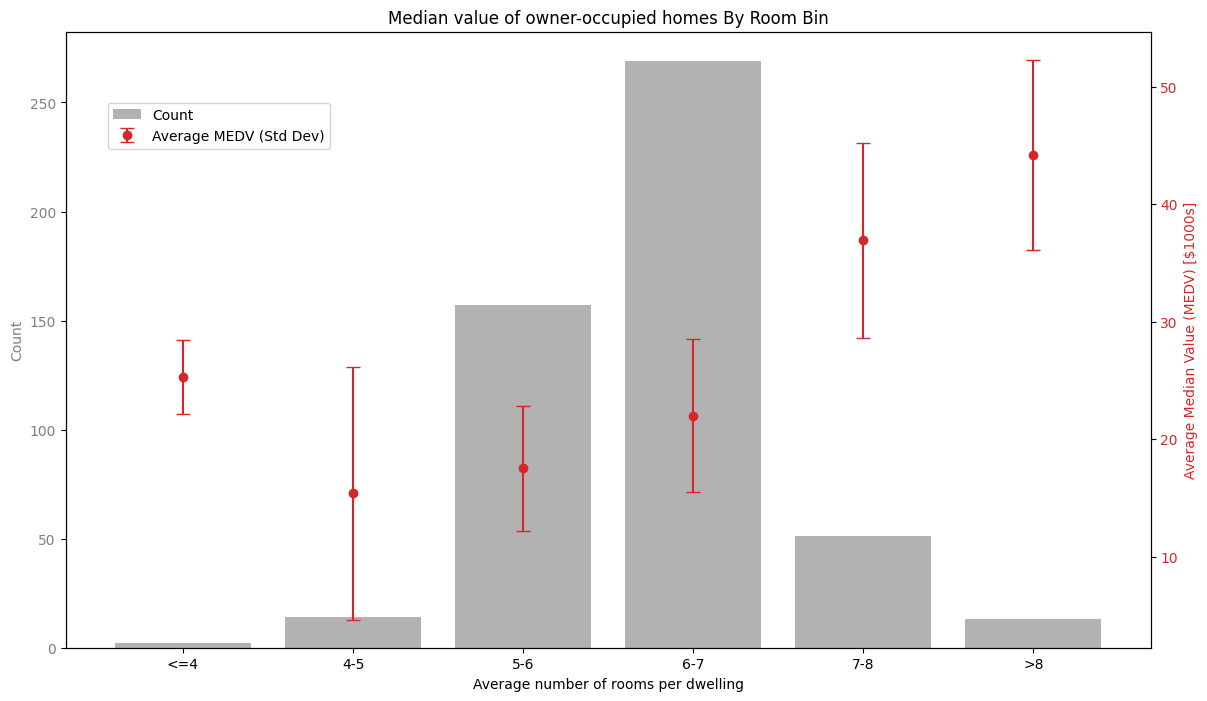

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = stats_df.toPandas()

# Plot the count of house in each bin as a bar chart
fig, ax1 = plt.subplots(figsize=(14, 8))
color = 'tab:gray'
ax1.set_xlabel('Average number of rooms per dwelling')
ax1.set_ylabel('Count', color=color)
bars = ax1.bar(pandas_df['room_bin'], pandas_df['count'], color=color, alpha=0.6, label='Count')
ax1.tick_params(axis='y', labelcolor=color)

# Plot average median value with error bars for standard deviation
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average Median Value (MEDV) [$1000s]', color=color)
lines = ax2.errorbar(pandas_df['room_bin'], pandas_df['average_medv'].astype(float),
                     yerr=pandas_df['std_dev_medv'].astype(float), fmt='o', color=color, ecolor=color, capsize=5, label='Average MEDV (Std Dev)')
ax2.tick_params(axis='y', labelcolor=color)

# legends
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.8))

# title
plt.title('Median value of owner-occupied homes By Room Bin')

# Show the plot
plt.show()

